## Categorized Linear Regression Analysis

This notebook documents the steps taken to perform categorized linear regression on the direct ink writing dataset

Input Parameters In Order
* Extruder Flowrate - Q (uL/min)
* Gantry Travel Speed - V<sub>g</sub> (mm/min)
* Layer Height (mm)

Output Parameters In Order
* Average Line Width - l<sub>w</sub>(μm)
* Average Line Height - l<sub>h</sub> (μm)

Code setup - importing useful libraries and extracting each parameter as a numpy array

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

filename = "clean_data.csv"

df = pd.read_csv(filename)

# print(df.columns)
# ['Q (uL/min)', 'Vg (mm/min)', 'Layer Height (mm)', 'Average Line Width (μm)', 'Average Line Height (μm)']

Q = df.loc[:, 'Q (uL/min)'].values

Vg = df.loc[:, 'Vg (mm/min)'].values

lw = df.loc[:, 'Average Line Width (μm)'].values

lh = df.loc[:, 'Average Line Height (μm)'].values    

### Plotting Q, V<sub>g</sub> to l<sub>w</sub> and l<sub>h</sub>


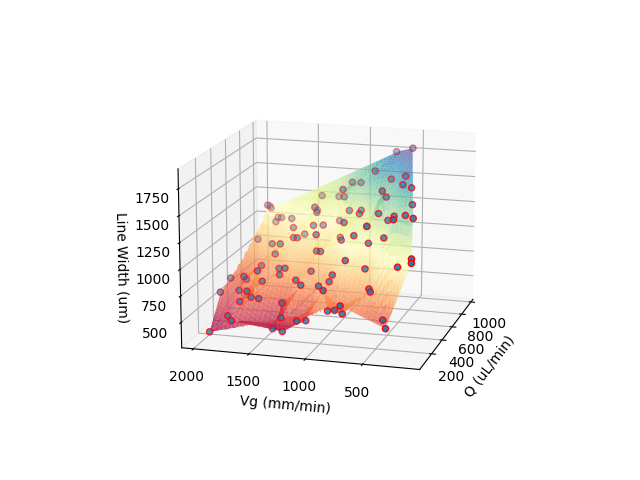

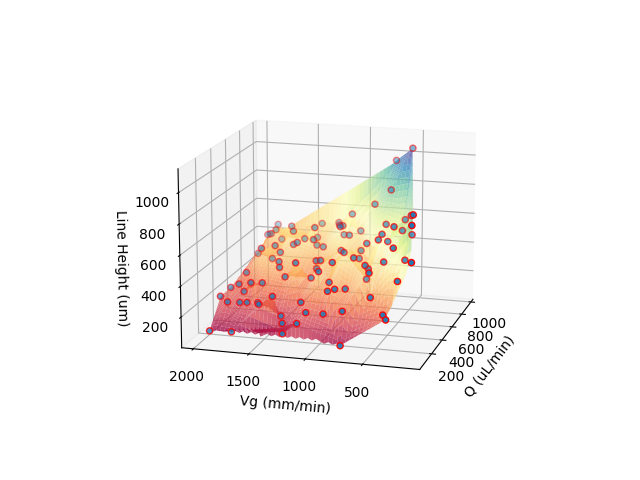

In [2]:
from scipy.interpolate import griddata

Q_inter = np.linspace(min(Q), max(Q), 500)
Vg_inter = np.linspace(min(Vg), max(Vg), 500)
Q_inter_mesh, Vg_inter_mesh = np.meshgrid(Q_inter, Vg_inter)

lw_inter = griddata((Q, Vg), lw, (Q_inter_mesh,
                                  Vg_inter_mesh), method='linear')

lh_inter = griddata((Q, Vg), lh, (Q_inter_mesh,
                                  Vg_inter_mesh), method='linear')

# Plot against line width first
fig = plt.figure()
ax = plt.axes(projection="3d")

surf = ax.plot_surface(Q_inter_mesh, Vg_inter_mesh,
                       lw_inter,  cmap=plt.cm.Spectral, alpha=0.75)
ax.scatter(Q, Vg, lw, edgecolor='r')
ax.view_init(elev=15, azim=-164)
ax.set_zlabel('Line Width (um)')

ax.set_xlabel('Q (uL/min)')
ax.set_ylabel('Vg (mm/min)')

plt.savefig("Q_Vg_Width.png", dpi=300)
plt.show()

# Plot against line height
fig = plt.figure()
ax = plt.axes(projection="3d")

surf = ax.plot_surface(Q_inter_mesh, Vg_inter_mesh,
                       lh_inter,  cmap=plt.cm.Spectral, alpha=0.75)
ax.scatter(Q, Vg, lh, edgecolor='r')
ax.view_init(elev=15, azim=-164)
ax.set_zlabel('Line Height (um)')

ax.set_xlabel('Q (uL/min)')
ax.set_ylabel('Vg (mm/min)')

plt.savefig("Q_Vg_Height.png", dpi=300)
plt.show()


Notice how the above plots seem to form a plane. The line width and line height appear to grow linearly as the ratio between Q and V<sub>g</sub> grows.

If we use the ratio Q/V<sub>g</sub> and call this variable liquid deposition rate LDR (uL/mm) and plot it against line width and height, we get what appears to be 3 segemented linear sections

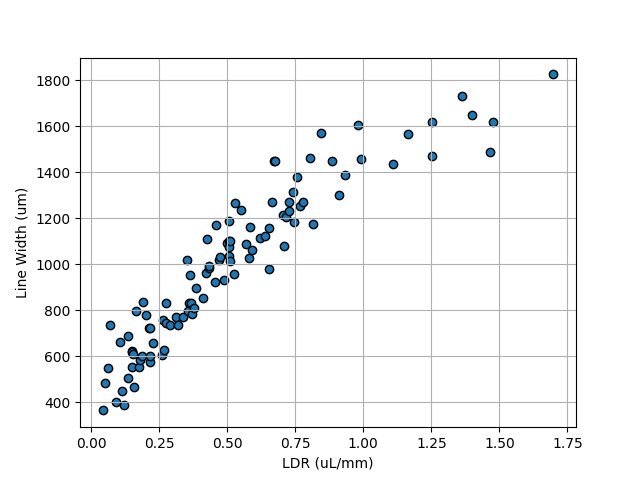

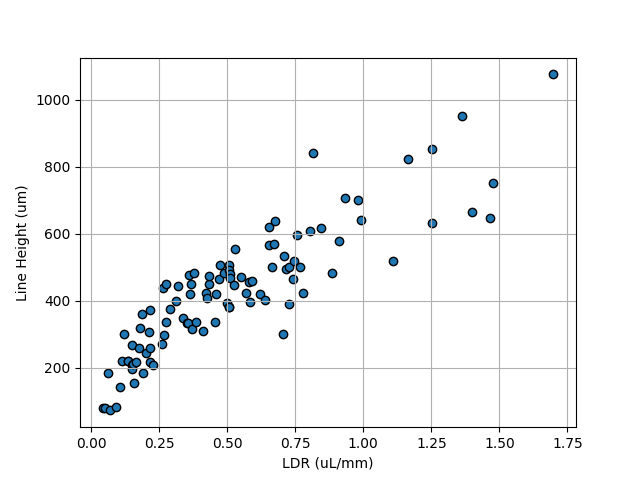

In [3]:
ldr = Q/Vg #(ul/mm)

# LDR against width
fig = plt.figure()
ax = plt.axes()
ax.grid()

ax.scatter(ldr, lw, edgecolor='k')

ax.set_xlabel('LDR (uL/mm)')
ax.set_ylabel('Line Width (um)')

plt.savefig("LDR_Width_unmarked.png", dpi=300)
plt.show()

# LDR against height
fig = plt.figure()
ax = plt.axes()
ax.grid()

ax.scatter(ldr, lh, edgecolor='k')

ax.set_xlabel('LDR (uL/mm)')
ax.set_ylabel('Line Height (um)')

plt.savefig("LDR_Height_unmarked.png", dpi=300)
plt.show()

### Performing Segmented Linear Regression

We'll now perform segmented linear regression to get the groups. First on line width


                    Breakpoint Regression Results                     
No. Observations                      101
No. Model Parameters                    6
Degrees of Freedom                     95
Res. Sum of Squares           1.01583e+06
Total Sum of Squares          1.19476e+07
R Squared                        0.914976
Adjusted R Squared               0.909549
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                394.867         33.0       11.964      1.15e-20       329.35       460.39
alpha1               1307.09     1.15e+02       11.335      2.41e-19       1078.2       1536.0
beta1               -377.969        2e+02      -1.8893             -      -775.12       19.185
beta2               -499.696     1.99e+02       -2.507             -      -895.39       -104.0
breakpoint1      

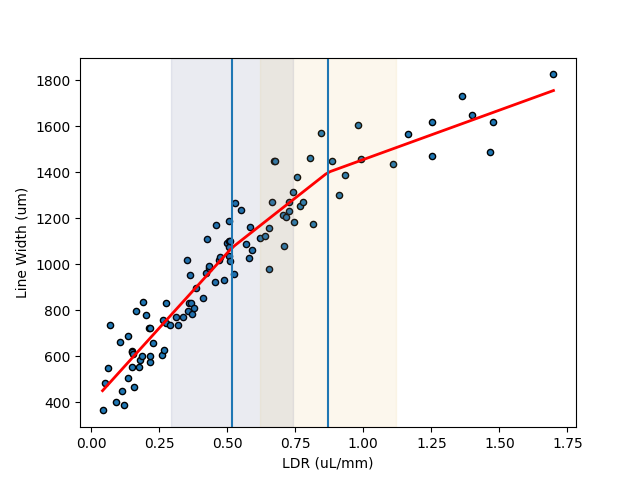

In [4]:
import piecewise_regression


# LDR against line width
lw_fit = piecewise_regression.Fit(ldr, lw, n_breakpoints=2)
lw_fit.summary()

plt.figure()
# Plot the data, fit, breakpoints and confidence intervals
lw_fit.plot_data(edgecolor='k', s=20)
# Pass in standard matplotlib keywords to control any of the plots
lw_fit.plot_fit(color="red", linewidth=2)
lw_fit.plot_breakpoints()
lw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel('LDR (uL/mm)')
plt.ylabel('Line Width (um)')
plt.savefig("LDR_Width_piecewise.png", dpi=300)
plt.show()

Now on line height


                    Breakpoint Regression Results                     
No. Observations                      101
No. Model Parameters                    6
Degrees of Freedom                     95
Res. Sum of Squares           6.46353e+05
Total Sum of Squares          3.49416e+06
R Squared                        0.815019
Adjusted R Squared               0.803212
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                48.7247         40.7       1.1982         0.234      -32.008       129.46
alpha1               1123.15     2.25e+02       4.9957      2.66e-06       676.82       1569.5
beta1               -819.256     2.79e+02      -2.9352             -      -1373.4      -265.15
beta2                108.214     1.73e+02      0.62726             -      -234.28       450.71
breakpoint1      

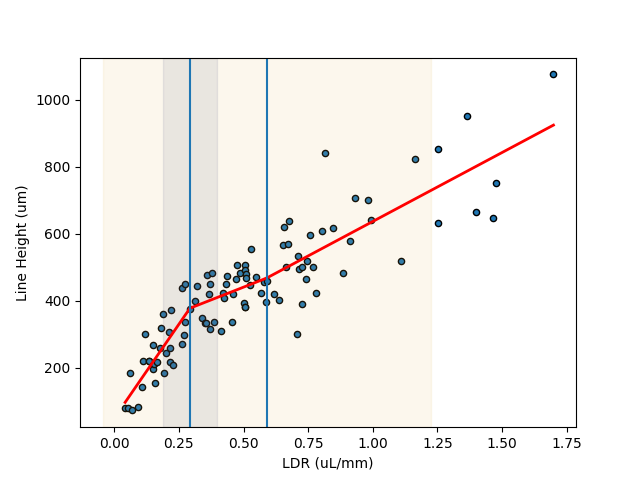

In [5]:
# LDR against line height
bk_guess = [0.286,0.6]
lh_fit = piecewise_regression.Fit(
    ldr, lh, start_values=bk_guess, max_iterations=1000)
lh_fit.summary()

plt.figure()
# Plot the data, fit, breakpoints and confidence intervals
lh_fit.plot_data(edgecolor='k', s=20)
# Pass in standard matplotlib keywords to control any of the plots
lh_fit.plot_fit(color="red", linewidth=2)
lh_fit.plot_breakpoints()
lh_fit.plot_breakpoint_confidence_intervals()
plt.xlabel('LDR (uL/mm)')
plt.ylabel('Line Height (um)')
plt.savefig("LDR_Height_piecewise.png", dpi=300)
plt.show()
